# Preprocessing and Modelling

**Introduction**

Fatalities due to traffic delays of emergency vehicles such as ambulance & fire brigade is a huge problem. In daily life, we often see that emergency vehicles face difficulty in passing through traffic. So differentiating a vehicle into an emergency and non emergency category can be an important component in traffic monitoring as well as self drive car systems as reaching on time to their destination is critical for these services. 

**Data**

The data is available in Analytics Vidhya (https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon)

**Data Science Method**
- Problem Identification
- Data Wrangling
- Exploratory Data Analysis
- **Pre-processing,Training Data Development and Modeling**
- Documentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

**Import Data**

In [22]:
path="/content/drive/My Drive/capstone/train"
os.chdir(path)

dir = os.path.join(path,'images/')
df_train = pd.read_csv('train.csv')
df_train['image_names'] = df_train['image_names'].map(lambda x: os.path.join(dir,x))
print(df_train.head())

submit = pd.read_csv('sample_submission.csv')
submit['image_names'] = submit['image_names'].map(lambda x: os.path.join(dir,x))
print(submit.head())

                                         image_names  emergency_or_not
0  /content/drive/My Drive/capstone/train/images/...                 0
1  /content/drive/My Drive/capstone/train/images/...                 0
2  /content/drive/My Drive/capstone/train/images/...                 0
3  /content/drive/My Drive/capstone/train/images/...                 0
4  /content/drive/My Drive/capstone/train/images/...                 0
                                         image_names  emergency_or_not
0  /content/drive/My Drive/capstone/train/images/...                 0
1  /content/drive/My Drive/capstone/train/images/...                 0
2  /content/drive/My Drive/capstone/train/images/...                 0
3  /content/drive/My Drive/capstone/train/images/...                 0
4  /content/drive/My Drive/capstone/train/images/...                 0


In [4]:
df_train.emergency_or_not.value_counts()

0    965
1    681
Name: emergency_or_not, dtype: int64

**Sample Images**

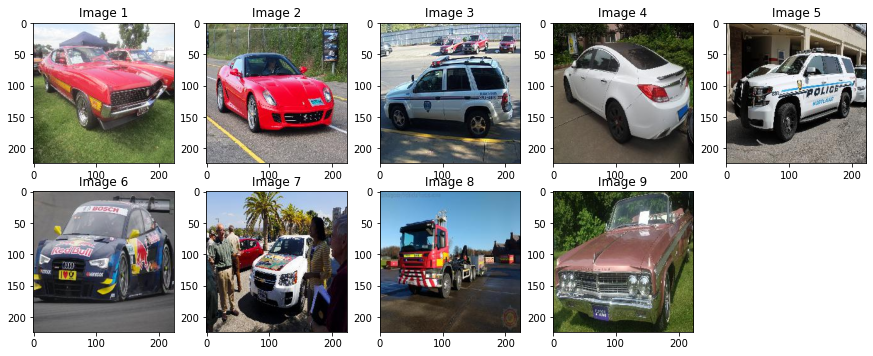

In [5]:
import cv2

count = 1
plt.figure(figsize=[15, 15])

for i in range(1,10):
    img = cv2.imread(df_train['image_names'][i])[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

Fast.ai library for training

In [6]:
from fastai.imports import *
from fastai import *
from fastai.vision import *
from torchvision.models import *
import torch

In [23]:
np.random.seed(123)

**Data Transformation**

In [24]:
tfms = get_transforms(do_flip = True, max_lighting = 0.2, max_zoom= 1.1, max_warp = 0, max_rotate = 45)


In [9]:
#test_img = ImageList.from_df(submit, path, folder='images')
#train = (ImageList.from_df(df_train, path, folder='images')
#       .split_by_rand_pct(0.2)
#       .label_from_df()
#       .add_test(test_img))

In [25]:
data = ImageDataBunch.from_csv(path, folder= 'images',
                              valid_pct = 0.0,
                              csv_labels = 'train.csv',
                              ds_tfms = tfms, 
                              fn_col = 'image_names',
                              label_col = 'emergency_or_not',
                              bs = 16,
                              size = 300).normalize(imagenet_stats)

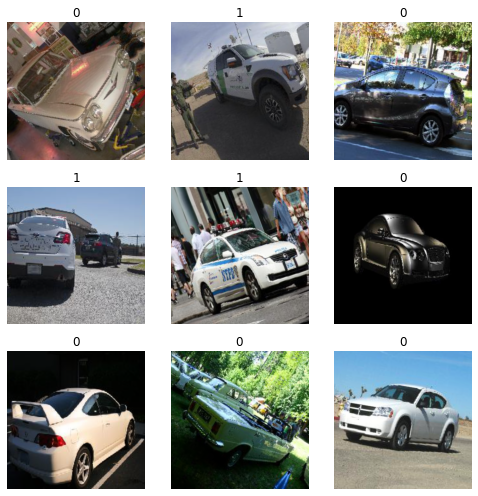

In [11]:
data.show_batch(rows=3, figsize=(7,7))

We normally use convolutional neural networks (CNN) for image classification. We will be using resnet101. To fit the model, we will be using *fit_one_cycle*. The top fully connected layers are unfrozen by default.

In [37]:
fbeta = FBeta(average='weighted', beta = 1)
learn = cnn_learner(data, models.resnet101, metrics=[accuracy, fbeta])

In [38]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
___________________________________________________

In [39]:
learn.fit_one_cycle(8)

In [15]:
#interp = ClassificationInterpretation.from_learner(learn)

In [16]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
#interp.plot_top_losses(9, fig_size=(15,11))

In [ ]:
# select the point with the largest decrease in loss
learn.lr_find()
learn.recorder.plot(suggestion=True)

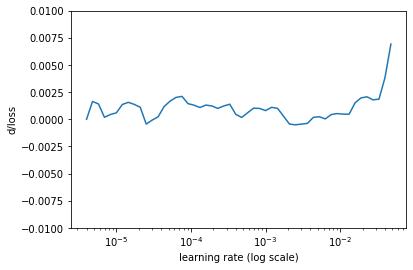

In [43]:
# adapted from https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
def plot_loss_change(recorder, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        recorder - learning rate recorder, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.recorder.lrs)):
        derivative = (learn.recorder.losses[i] - learn.recorder.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.recorder.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

plot_loss_change(learn.recorder, sma=20)

In [40]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

**Automated Learining Rate Finder** 
By Andrew Chang https://forums.fast.ai/t/automated-learning-rate-suggester/44199

In [41]:
find_appropriate_lr(learn)

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


0.0030199517204020187

Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


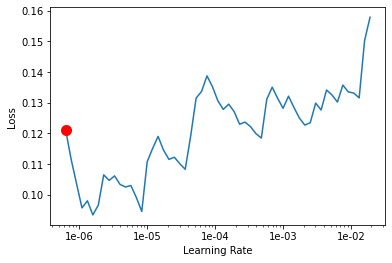

In [42]:
learn.recorder.plot(suggestion=True)

**Parameter Tuning**

In [44]:
learn.fit(epochs = 8, lr = 1.3e-6)

In [45]:
# unfreeze other layers
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1.3e-6, 1.3e-4), wd=0.1)

In [48]:
learn.save('model')

# New Section